<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/data-exploration/training_at_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install tf-nightly-2.0-preview

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190511


### Global constants

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160 
BATCH_SIZE = 25

CLASS_MODE = 'categorical'

NUM_OF_CLASSES = 2
CLASS_NAMES = ['tumor', 'non_tumor']


### Setting up GCP

In [0]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

In [5]:
!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


### Read Data from GCP

In [0]:
LEVEL = 5

In [0]:
TRAIN_DIR = "/tmp/train/"
GCP_TRAIN_DIR = "train/level{}/".format(LEVEL)
LEVEL_TRAIN_DIR = "/tmp/train/level{}".format(LEVEL)

TEST_DIR = "/tmp/test/"
GCP_TEST_DIR = "test/level{}/".format(LEVEL)
LEVEL_TEST_DIR = "/tmp/test/level{}".format(LEVEL)

In [0]:
!rm -rf '$TRAIN_DIR'
!rm -rf '$TEST_DIR'

!mkdir -p '$TRAIN_DIR'
!mkdir -p '$TEST_DIR'

### Download Level data into Train/Test Directories

In [9]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TRAIN_DIR} {TRAIN_DIR}
  
print("\nDownloaded Train Data")

print("# Non Tumor files")
!ls "$LEVEL_TRAIN_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TRAIN_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_108800_tumor_078.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_96000_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_035.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_057.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_12800_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_32000_tumor_096.tif...
Copying gs://vaa2114_dl_201

In [10]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TEST_DIR} {TEST_DIR}
  
print("\nDownloaded Test Data")

print("# Non Tumor files")
!ls "$LEVEL_TEST_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TEST_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_121600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_128000_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_217600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_134400_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_19200_tumor_084.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_256

### Util functions

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def getModel(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(216, activation='relu'))
  model.add(Dense(NUM_OF_CLASSES, activation='softmax'))
  
  return model

In [0]:
# Compile and build

def trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, EPOCHS):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

  history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
        verbose=2)
  
  return history

In [0]:
# Print Train/Validate accuracy and loss

def plotTrainVal(history, EPOCHS):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, EPOCHS+1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Image Generators w/ Data Augmentation

In [16]:
# image_gen_train = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

image_gen_train = ImageDataGenerator(rescale=1/.255)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TRAIN_DIR, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode=CLASS_MODE)


# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TEST_DIR,                     # Using Test data for validation
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

# Test data should not be augmented!
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TEST_DIR, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)


Found 858 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [0]:
total_train = 858
total_val = 260
total_test = 260

### Sample Training Data after Data Augmentation

W0511 18:26:45.082107 139862450579328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0511 18:26:45.085628 139862450579328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0511 18:26:45.093189 139862450579328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0511 18:26:45.096621 139862450579328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0511 18:26:45.100471 139862450579328 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


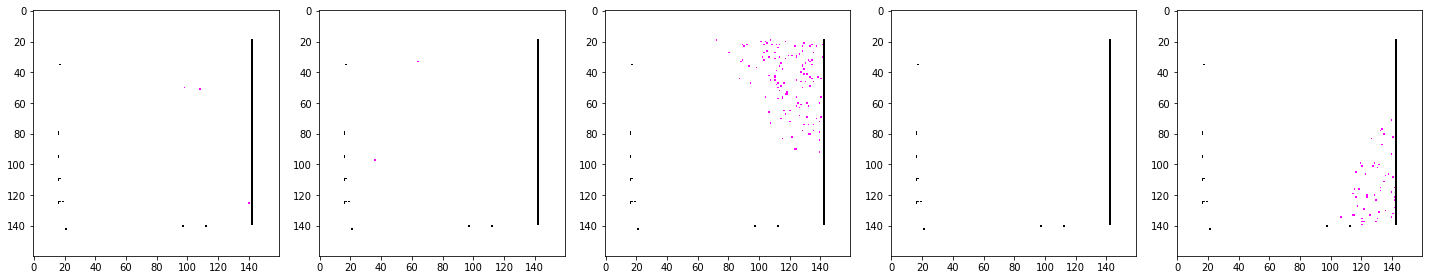

In [30]:
sample_training_images, sample_training_labels = next(train_data_gen)

plotImages(sample_training_images[:5])

### Sample Validation data

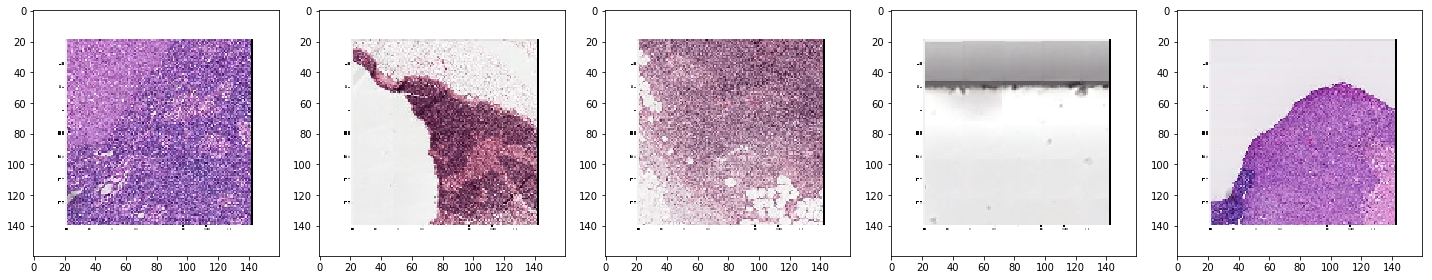

In [26]:
sample_val_images, sample_val_labels = next(val_data_gen)

plotImages(sample_val_images[:5])

### Sample Test Data

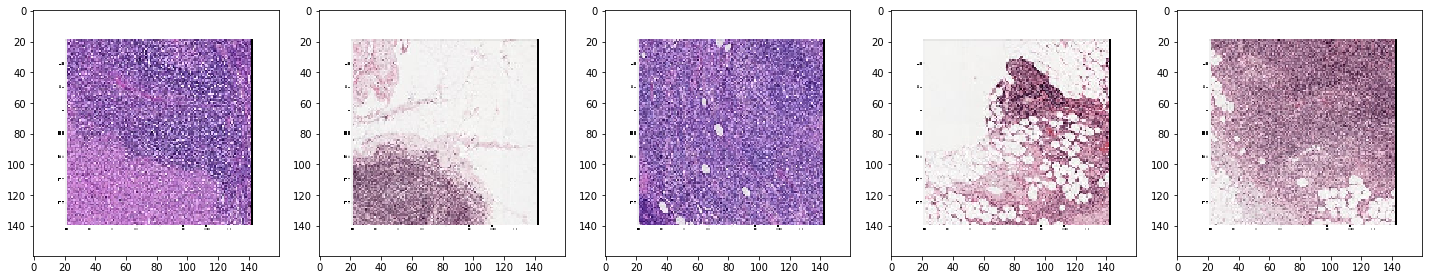

In [27]:
sample_test_images, sample_test_labels = next(test_data_gen)

plotImages(sample_test_images[:5])

### Train with Mobile Net

In [0]:
mobile_net = applications.MobileNetV2(weights='imagenet',include_top=False, input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

conv_base = mobile_net
conv_base.trainable = False

model_mobile = getModel(conv_base)

In [32]:
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 216)               6912216   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 434       
Total params: 9,170,634
Trainable params: 6,912,650
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
%%time

EPOCHS = 10

history_mobile = trainModel(model_mobile, total_train, total_val, 
           train_data_gen, val_data_gen, EPOCHS)

Epoch 1/10
35/35 - 108s - loss: 3.6701 - acc: 0.7669 - val_loss: 4.4251 - val_acc: 0.7385
Epoch 2/10
35/35 - 92s - loss: 3.7450 - acc: 0.7704 - val_loss: 4.1614 - val_acc: 0.7385
Epoch 3/10
35/35 - 93s - loss: 3.6689 - acc: 0.7704 - val_loss: 4.1614 - val_acc: 0.7385
Epoch 4/10
35/35 - 78s - loss: 3.6689 - acc: 0.7704 - val_loss: 4.0735 - val_acc: 0.7385
Epoch 5/10
35/35 - 78s - loss: 3.7831 - acc: 0.7704 - val_loss: 4.3372 - val_acc: 0.7385
Epoch 6/10
35/35 - 100s - loss: 3.7070 - acc: 0.7704 - val_loss: 4.2493 - val_acc: 0.7385
Epoch 7/10
35/35 - 113s - loss: 3.6689 - acc: 0.7704 - val_loss: 4.2493 - val_acc: 0.7385
Epoch 8/10
35/35 - 112s - loss: 3.7831 - acc: 0.7704 - val_loss: 4.3372 - val_acc: 0.7385
Epoch 9/10
35/35 - 114s - loss: 3.7070 - acc: 0.7704 - val_loss: 4.2493 - val_acc: 0.7385
Epoch 10/10
35/35 - 112s - loss: 3.6689 - acc: 0.7704 - val_loss: 4.2493 - val_acc: 0.7385
CPU times: user 24min 44s, sys: 29.9 s, total: 25min 14s
Wall time: 16min 40s


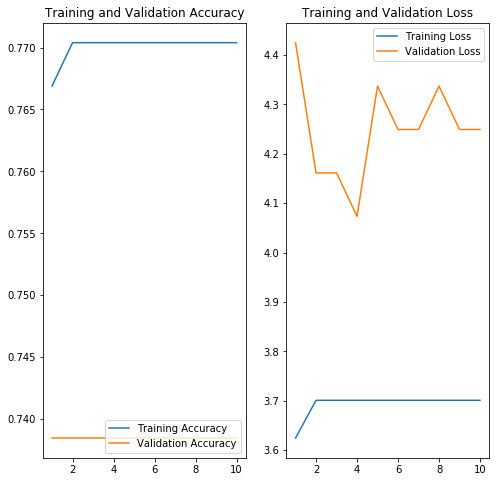

In [35]:
plotTrainVal(history_mobile, EPOCHS)

Confusion matrix, without normalization
[[19  0]
 [ 6  0]]


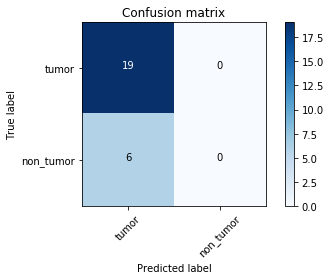

In [36]:
predictions_mobile = model_mobile.predict(sample_test_images)
y_pred_1= np.argmax(predictions_mobile, axis=1)

confusion_matrix_mobile = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_pred_1)
plot_confusion_matrix(confusion_matrix_mobile, CLASS_NAMES)

In [0]:
# EPOCHS = 3

# history_my_model_1 = trainModel(my_model_1, total_train, total_val, 
#            train_data_gen, val_data_gen, EPOCHS)

In [0]:
# ## Creating a Convolutional model
# my_model_1 = Sequential()
# my_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
# my_model_1.add(MaxPooling2D((2, 2)))
# my_model_1.add(Conv2D(64, (3, 3), activation='relu'))
# my_model_1.add(MaxPooling2D((2, 2)))
# my_model_1.add(Conv2D(128, (3, 3), activation='relu'))
# my_model_1.add(MaxPooling2D((2, 2)))
# my_model_1.add(Conv2D(128, (3, 3), activation='relu'))
# my_model_1.add(MaxPooling2D((2, 2)))
# my_model_1.add(Flatten())
# my_model_1.add(Dropout(0.5))
# my_model_1.add(Dense(256, activation='relu'))
# my_model_1.add(Dense(64, activation='relu'))
# my_model_1.add(Dense(NUM_OF_CLASSES, activation='softmax'))

In [0]:
# my_model_1.summary()

In [21]:
# predictions1 = my_model_1.predict(sample_test_images)
# y_pred_1= np.argmax(predictions1, axis=1)

# confusion_matrix_1 = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_pred_1)
# plot_confusion_matrix(confusion_matrix_1, CLASS_NAMES)

NameError: ignored